In [105]:
def plot(data, collection, ax, fig, i, cum):
    data["timestamp"] = data["timestamp"].apply(lambda x: x["value"])
    data["timestamp_iota"] = data["timestamp_iota"].apply(lambda x: x["value"])
    data["timestamp_subscription"] = data["timestamp_subscription"].apply(lambda x: int(x * 1000))
    data["timestamp_kafka"] = data["timestamp_kafka"].apply(lambda x: int(x * 1000))

    mint = data["timestamp"].min()
    data["timestamp"] = data["timestamp"] - mint
    data["timestamp_iota"] = data["timestamp_iota"] - mint
    data["timestamp_subscription"] = data["timestamp_subscription"] - mint
    data["timestamp_kafka"] = data["timestamp_kafka"] - mint
    data.columns = [x.replace("timestamp_", "").replace("timestamp", "device") for x in data.columns]

    for c in data.columns:
        data[c] = data[c].apply(lambda x: int(x / 1000))

    for c in data.columns:
         data.groupby([c])[[c]].count().plot.line(ax=ax, legend=i == 0)
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.set_axisbelow(True)
    ax.grid(visible=True, which='major', linestyle='-', axis='y')
    ax.set_yscale('log')
    setup = json.loads('{"' + collection.replace("mission_TEST--", "").replace("--", '","').replace("-", '":"') + '"}')
    ax.set_title("$dev={},freq={},msg/s={}$".format(setup["dev"], setup["freq"], int(setup["freq"]) * int(setup["dev"])))

error
error


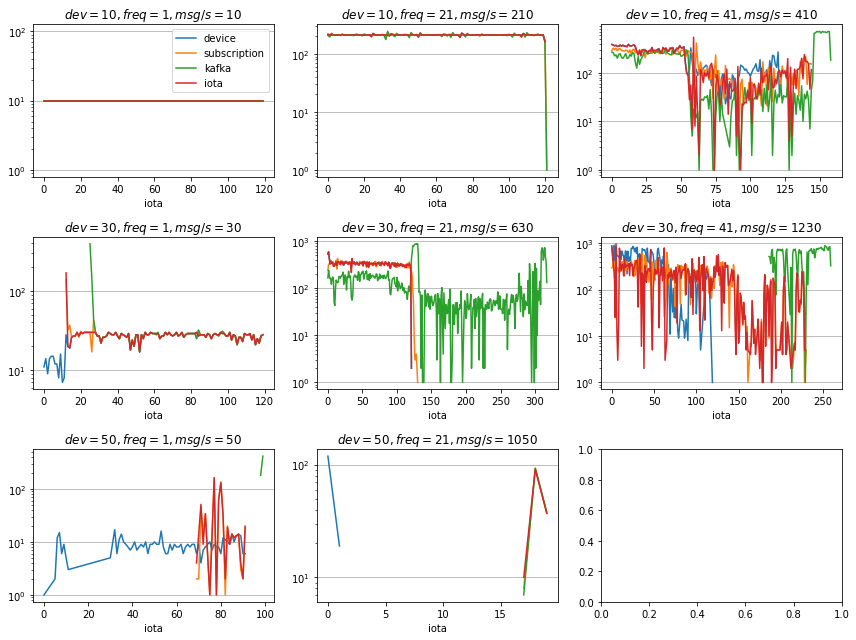

In [106]:
import pymongo
import matplotlib.pyplot as plt
import json


    
db_connect = pymongo.MongoClient('127.0.0.1', 37017)
database_name = 'persistence'
database = db_connect[database_name]
collections = sorted([x for x in database.list_collection_names() if "TEST" in x])
cols = 3
rows = int(len(collections) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(4 * rows, 3 * cols))
i = 0
for collection in collections:
    try:
        data = pd.DataFrame(list(database[collection].find()))[["timestamp", "timestamp_subscription", "timestamp_kafka", "timestamp_iota"]]
        data = data.dropna()
        ddata = data.copy(deep=True)
        plot(ddata, collection, axs[int(i / cols)][i % cols], fig, i, False)
        ddata = data.copy(deep=True)
        plot(ddata, collection, axs[int(i / cols)][i % cols], fig, i, True)
    except:
        print("error")
    i += 1
fig.tight_layout()